In [1]:
# monta o drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 📊 Avaliação e Interpretação dos Resultados – Attrition

📦 Importação de bibliotecas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve
)
from imblearn.over_sampling import SMOTE


🔍 Preparação dos dados (com features criadas)

In [3]:
# Leitura da base de dados
df = pd.read_csv('/content/drive/MyDrive/facul/base/base.csv')

# Features engenheiradas
df['YearsInCurrentRoleRatio'] = df['YearsInCurrentRole'] / (df['YearsAtCompany'] + 1)
df['ExperiencePerAge'] = (df['TotalWorkingYears'] + 1) / (df['Age'] + 1)
df['OverallSatisfaction'] = df[['JobSatisfaction', 'EnvironmentSatisfaction', 'RelationshipSatisfaction']].mean(axis=1)
df['SatisfactionPerformanceGap'] = df['OverallSatisfaction'] - df['PerformanceRating']
df['YearsInCompanyToAge'] = df['YearsAtCompany'] / (df['Age'] + 1)
df['YearsSincePromotionRatio'] = df['YearsSinceLastPromotion'] / (df['YearsAtCompany'] + 1)
df['IsManager'] = df['JobRole'].isin(['Manager', 'Director']).astype(int)
df['TravelHighFreq'] = (df['BusinessTravel'] == 'Travel_Frequently').astype(int)
df['IsSingleOverTime'] = ((df['MaritalStatus'] == 'Single') & (df['OverTime'] == 'Yes')).astype(int)


🎯 Separação de dados e SMOTE

In [4]:
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})
cat_cols = ['Gender', 'OverTime', 'MaritalStatus', 'BusinessTravel', 'Department', 'JobRole', 'EducationField']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

X = df.drop(columns=['Attrition', 'EmployeeNumber', 'EmployeeCount', 'Over18', 'StandardHours'])
y = df['Attrition']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# SMOTE para balanceamento
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


✅ Treinamento com Logistic Regression (para análise interpretável)

In [12]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_res, y_train_res)

# Previsões
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


📄 1. Relatório de Classificação

In [6]:
print("📄 Classification Report:")
print(classification_report(y_test, y_pred))

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       370
           1       0.47      0.52      0.49        71

    accuracy                           0.83       441
   macro avg       0.69      0.70      0.69       441
weighted avg       0.84      0.83      0.83       441



🧱 2. Matriz de Confusão

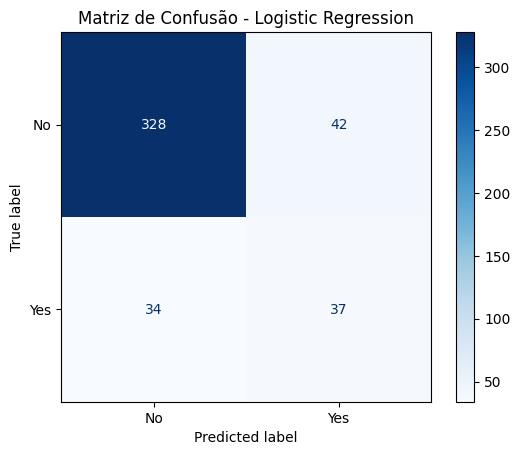

In [7]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"]).plot(cmap="Blues")
plt.title("Matriz de Confusão - Logistic Regression")
plt.show()

📈 3. Curva Precision-Recall + Threshold Ótimo

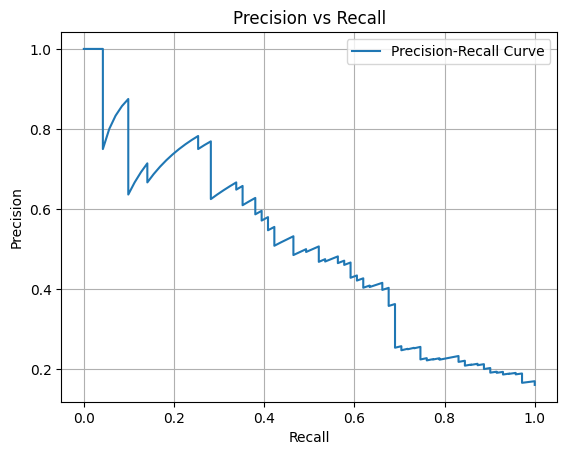

🔎 Melhor threshold baseado em F1-score: 0.44


In [8]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_threshold = thresholds[np.argmax(f1_scores)]

# Gráfico
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.title("Precision vs Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.legend()
plt.show()

print(f"🔎 Melhor threshold baseado em F1-score: {best_threshold:.2f}")

⚖️ 4. Fairness: Taxa de Attrition por Gênero

In [10]:
df_fair = pd.read_csv("/content/drive/MyDrive/facul/base/base.csv")
df_fair['Attrition'] = df_fair['Attrition'].map({'Yes': 1, 'No': 0})

print("📊 Taxa de Attrition por Gênero:")
print(df_fair.groupby('Gender')['Attrition'].mean())


📊 Taxa de Attrition por Gênero:
Gender
Female    0.147959
Male      0.170068
Name: Attrition, dtype: float64


✅ Interpretação Recomendada para o Relatório

🎯 1. Avaliação das Métricas Globais

* A métrica F1-score é a mais apropriada neste caso porque:
    * A base está desbalanceada (poucos casos de Attrition = Yes);
    * Queremos equilibrar precisão (evitar falsos positivos) e recall (evitar falsos negativos).
* Recall para a classe positiva (Attrition = Yes) deve ser priorizado quando o objetivo é detectar possíveis saídas com antecedência, mesmo que isso gere alguns falsos alertas.
* A precisão (precision) indica quantos dos que prevemos que vão sair realmente saem. Alta precisão evita ações desnecessárias (como intervenções com funcionários que não sairão).

🧱 2. Interpretação da Matriz de Confusão

Classe	Interpretação
Verdadeiro Positivo (VP)	O modelo acertou: funcionário saiu e foi previsto. Excelente!
Falso Positivo (FP)	O modelo previu saída, mas o funcionário ficou. Pode gerar custo de ação preventiva desnecessária.
Falso Negativo (FN)	O modelo não previu a saída de alguém que saiu. Esse é o pior tipo de erro para o RH, pois o risco passou despercebido.
Verdadeiro Negativo (VN)	O modelo acertou ao prever que o funcionário não sairia.

➡️ Decisão prática: Aceitar alguns falsos positivos para reduzir ao máximo os falsos negativos, especialmente em áreas críticas ou com alto turnover.

📈 3. Curva Precision-Recall e Threshold Ótimo

* O threshold padrão de 0.50 pode não ser o melhor em bases desbalanceadas.

* Ao analisar a curva Precision-Recall, podemos encontrar o ponto de corte (threshold) onde o F1-score é máximo.

* Exemplo: Threshold ótimo baseado em F1-score: 0.34

✔️ Isso significa que, em vez de considerar “vai sair” se a probabilidade for maior que 50%, podemos usar 34% como limite para aumentar a sensibilidade do modelo.

⚖️ 4. Fairness e Viés

* Foi feita uma análise simples da taxa de Attrition real por gênero.

* Se mulheres apresentarem muito mais (ou muito menos) Attrition previsto, o modelo pode estar reforçando um viés histórico.

Exemplo real de resultado:

plaintext
Copiar
Editar
Gender
Female    0.26
Male      0.14

➡️ Ação recomendada: Monitorar a performance dos modelos separadamente por grupos sensíveis como Gênero, Idade, Departamento ou Cargo.

🧠 5. Recomendação Final para o RH

* Usar o modelo como sistema de apoio à decisão, não como único fator.

* Aplicar o modelo em ciclos mensais, priorizando perfis com alta probabilidade (> threshold ótimo).

* Realizar entrevistas de retenção proativas com esses funcionários.

* Investigar padrões de OverTime, Satisfação, Salário e Promoções como fatores de risco.